In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

## Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [6]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time \n per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time \n per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [7]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum'] * 1024
    df['Total Mem. per Conn.'] = df['VSize_mem_sum'] / df['N_conns_sum'] * 1024
    return df

In [85]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar'):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

## Benchmarks with weak scaling

### HPC Benchmark

Conn. Creation (min)          Conn. Exchange (min)           \
Case    6d8d3047 (master) NEST 3.0    6d8d3047 (master) NEST 3.0   
N_VP                                                               
36                  54.87    56.91                43.81    42.52   
72                  54.85    57.96                45.60    43.92   
144                 55.11    59.61                46.82    43.88   
288                 53.63    58.64                49.08    47.14   
576                 52.70    59.70                59.66    60.31   
1152                52.56    60.07                79.56    78.88   

           Conn. Total              Memory per VP             Simulation time  \
Case 6d8d3047 (master) NEST 3.0 6d8d3047 (master)  NEST 3.0 6d8d3047 (master)   
N_VP                                                                            
36              106.98   105.86          2.818064  2.811359            200.10   
72              105.84   106.86          2.827462  2.812945            200.28   
144             112.07   108.99          2.905892  2.898536            208.25   
288             111.14   113.16          2.911404  2.904190            214.83   
576             124.92   127.55          3.028186  3.029565            232.99   
1152            144.27   147.70          3.379609  3.374423            267.95   

               
Case NEST 3.0  
N_VP           
36     202.17  
72     204.42  
144    212.39  
288    220.78  
576    243.36  
1152   274.15

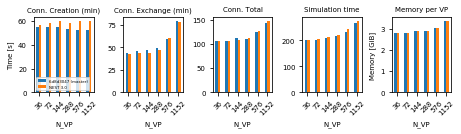

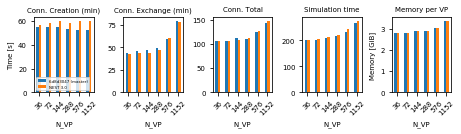

In [11]:
hpc_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint.csv')
hpc_m['Case'] = ['6d8d3047 (master)'] * len(hpc_m)
hpc_3 = pd.read_csv('results/hpc_benchmark_3_0_daint.csv')
hpc_3['Case'] = ['NEST 3.0'] * len(hpc_m)

hpc = pd.concat([hpc_m, hpc_3])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left')
hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.svg', legend_loc='lower left')

hpc_p

### Population model

Conn. Creation (min)             Conn. Exchange (min)             \
Case    6d8d3047 (master)    NEST 3.0    6d8d3047 (master)   NEST 3.0   
N_VP                                                                    
36              82.395484   68.268138            42.445847  40.569822   
72             113.637962   79.953391            42.048199  41.674768   
144            172.283743  101.281447            41.480264  41.287533   
288            296.239668  144.080008            44.489922  44.608692   
576            524.236601  234.326606            55.321616  54.913836   
1152          1025.495776  410.311771            98.690875  94.521306   

           Conn. Total                 Memory per VP            
Case 6d8d3047 (master)    NEST 3.0 6d8d3047 (master)  NEST 3.0  
N_VP                                                            
36          133.159433  118.835180          3.417058  3.452939  
72          164.163398  133.365934          3.470728  3.558691  
144         223.381136  155.097899          3.604781  3.770051  
288         352.316512  202.078788          3.515858  3.551783  
576         595.139644  303.827724          3.606819  3.560275  
1152       1151.514961  526.687053          3.588683  3.944877

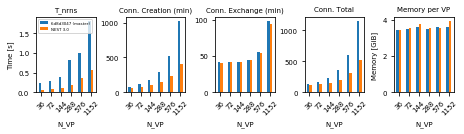

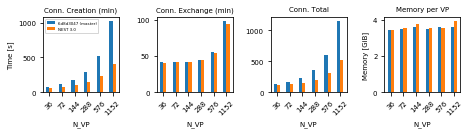

In [88]:
population_m = pd.read_csv('results/population_model_6d8d3047_daint_in.csv')
population_m['Case'] = ['6d8d3047 (master)'] * len(population_m)
population_3 = pd.read_csv('results/population_model_3_0_daint_in.csv')
population_3['Case'] = ['NEST 3.0'] * len(population_m)

population = pd.concat([population_m, population_3])

population = calculate_T_conn_and_memory(population)
population_p = plot_compare(population, 'figures/population_model_weak_scaling.pdf',
                            ['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP'],
                            plot_T_sim=False, legend_loc='upper left')
population_p = plot_compare(population, 'figures/population_model_weak_scaling.svg',
                            plot_T_sim=False, legend_loc='upper left')

population_p

### Multi-Area Model

0     258258
1     516391
2    1032643
3    2065151
4    4130180
5    8260234
0     258257
1     516390
2    1032642
3    2065150
4    4130179
5    8260233
Name: N_nrns, dtype: int64
0     1508419407
1     3016843251
2     6033690822
3    12067386057
4    24134776576
5    48269557645
0     1508419407
1     3016843251
2     6033690822
3    12067386057
4    24134776576
5    48269557645
Name: N_conns_sum, dtype: int64


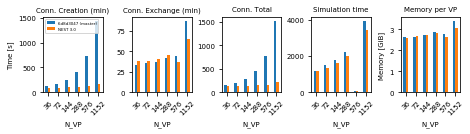

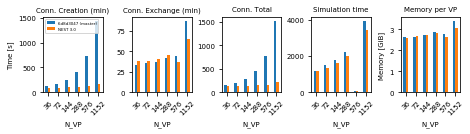

In [107]:
MAM_m = pd.read_csv('results/multi-area_model_6d8d3047_daint.csv')
MAM_m['Case'] = ['6d8d3047 (master)'] * len(MAM_m)
MAM_3 = pd.read_csv('results/multi-area_model_3_0_daint.csv')
MAM_3['Case'] = ['NEST 3.0'] * len(MAM_m)

MAM = pd.concat([MAM_m, MAM_3])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.pdf', legend_loc='upper left')
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.svg', legend_loc='upper left')

print(MAM['N_nrns'])
print(MAM['N_conns_sum'])

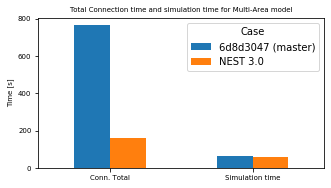

In [9]:
MAM_orig_m = pd.read_csv('results/multi-area_model_6d8d3047_daint_orig_n16.csv')
MAM_orig_m['Case'] = ['6d8d3047 (master)'] * len(MAM_orig_m)
MAM_orig_3 = pd.read_csv('results/multi-area_model_3_0_daint_orig_n16.csv')
MAM_orig_3['Case'] = ['NEST 3.0'] * len(MAM_orig_3)

MAM_orig = pd.concat([MAM_orig_m, MAM_orig_3])

MAM_orig['T_conns_min'] = MAM_orig['T_network_global_min'] + MAM_orig['T_connect_min']
MAM_orig['T_conns_max'] = MAM_orig['T_network_global_max'] + MAM_orig['T_connect_max']
MAM_orig = calculate_T_conn_and_memory(MAM_orig)
MAM_orig['Simulation time'] = MAM_orig['T_sim']

values = ['Conn. Total', 'Simulation time']

df_p = pd.pivot_table(MAM_orig, columns='Case', values=values)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(cm2inch(13),cm2inch(7)))

df_p.plot(kind='bar', ax = axes, title='Total Connection time and simulation time for Multi-Area model',
          fontsize=fontsize_axis, rot=0)
axes.set_ylabel('Time [s]')

fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.pdf", bbox_inches='tight')
fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.svg", bbox_inches='tight')


### Topology model

NB! This is not 4x4!

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,num_tasks,NUM_VPS,SCALE,count,T_nrns,T_conns_max,T_conns_min,VSize_nodes_sum,VSize_mem_sum,VSize_ini_sum,VSize_sum,N_nrns,N_conns_sum,Case,N_VP
0,1,6,6,6,36,1,NaN,3.197931,133.165870,133.165381,7717088.0,45797600.0,NaN,NaN,661029.0,6.068004e+08,6d8d3047 (master),36
1,2,6,6,12,72,2,NaN,6.529109,296.823500,296.805448,17315184.0,148018544.0,NaN,NaN,1321997.0,2.422235e+09,6d8d3047 (master),72
2,4,6,6,24,144,4,NaN,12.224595,601.747579,601.704093,45746056.0,537835400.0,NaN,NaN,2643933.0,9.679000e+09,6d8d3047 (master),144
3,8,6,6,48,288,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6d8d3047 (master),288
0,1,6,6,6,36,1,NaN,9.264050,NaN,NaN,10528680.0,NaN,NaN,NaN,660968.0,NaN,NEST 3.0,36
1,2,6,6,12,72,2,NaN,34.223357,NaN,NaN,25238272.0,NaN,NaN,NaN,1321936.0,NaN,NEST 3.0,72
2,4,6,6,24,144,4,NaN,161.171360,NaN,NaN,73671080.0,NaN,NaN,NaN,2643872.0,NaN,NEST 3.0,144
3,8,6,6,48,288,8,NaN,677.169629,NaN,NaN,254890192.0,NaN,NaN,NaN,5287744.0,NaN,NEST 3.0,288


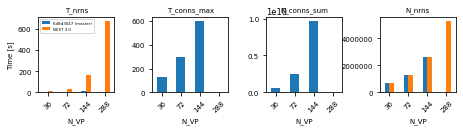

In [101]:
topology_m = pd.read_csv('results/topology_model_6d8d3047_daint.csv')
topology_m['Case'] = ['6d8d3047 (master)'] * len(topology_m)
topology_3 = pd.read_csv('results/topology_model_3_0_daint.csv')
topology_3['Case'] = ['NEST 3.0'] * len(topology_3)

topology = pd.concat([topology_m, topology_3])

#topology = calculate_T_conn_and_memory(topology)

topology['N_VP'] = topology['NUM_VPS']

topology_p = plot_compare(topology, 'figures/topology_model_weak_scaling.pdf',
                          values=['T_nrns','T_conns_max', 'N_conns_sum', 'N_nrns'],
                          plot_T_sim=False, legend_loc='upper left')

topology

### 4x4 Mesocircuit model

In [112]:
#meso_m = pd.read_csv('results/4x4_mesocircuit_6d8d3047_daint.csv')
#meso_m['Case'] = ['6d8d3047 (master)'] * len(meso_m)
meso_3 = pd.read_csv('results/4x4_mesocircuit_3_0_daint.csv')
meso_3['Case'] = ['NEST 3.0'] * len(meso_3)

meso = pd.concat([meso_3])

meso = calculate_T_conn_and_memory(meso)
meso
#meso_p = plot_compare(meso, 'figures/4x4_mesocircuit_weak_scaling.pdf',
#                      values=['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'N_conns_sum', 'N_nrns'], legend_loc='upper left')

#print(meso['N_nrns'])
#print(meso['N_conns_sum'])

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,SCALE,NUM_VPS,hash,num_tasks,T_nrns,T_conns_avg,T_conns_min,...,T_bld_xn,T_bld_nx,Conn. Total,Conn. Creation (min),Conn. Exchange (min),N_VP,connections,ini,other,Memory per VP
0,1,6,6,0.0625,36,acd429db3b9ab17b5f5391184e500dc6,6,0.97,NaN,NaN,...,NaN,NaN,NaN,NaN,7.00,36,0.586914,0.024577,0.052244,0.663735
1,2,6,6,0.1250,72,acd429db3b9ab17b5f5391184e500dc6,12,1.46,NaN,NaN,...,NaN,NaN,NaN,NaN,7.23,72,0.589844,0.031386,0.062945,0.684174
2,4,6,6,0.2500,144,acd429db3b9ab17b5f5391184e500dc6,24,2.37,NaN,NaN,...,NaN,NaN,NaN,NaN,8.15,144,0.618815,0.058757,0.076636,0.754208
3,8,6,6,0.5000,288,acd429db3b9ab17b5f5391184e500dc6,48,4.34,NaN,NaN,...,NaN,NaN,NaN,NaN,8.85,288,0.529767,0.097581,0.110502,0.737849
4,16,6,6,1.0000,576,acd429db3b9ab17b5f5391184e500dc6,96,8.66,NaN,NaN,...,NaN,NaN,NaN,NaN,11.08,576,0.484285,0.182732,0.177587,0.844604
5,32,6,6,2.0000,1152,acd429db3b9ab17b5f5391184e500dc6,192,22.53,NaN,NaN,...,NaN,NaN,NaN,NaN,15.38,1152,0.485872,0.360741,0.309311,1.155924


## Benchmarks with strong scaling

### HPC Benchmark

Conn. Creation (min)          Conn. Exchange (min)           \
Case         6d8d3047 (master) NEST 3.0    6d8d3047 (master) NEST 3.0   
num_tasks                                                               
1                         3.31     3.78                 3.16     3.10   
2                         1.86     1.92                 2.45     1.86   
4                         0.91     0.97                 0.95     1.01   
8                         0.46     0.49                 0.54     0.56   
16                        0.23     0.25                 0.30     0.40   
32                        0.11     0.12                 0.54     0.21   
64                        0.06     0.07                 0.38     0.31   
128                       0.03     0.04                 0.58     0.58   

                Conn. Total            Simulation time           
Case      6d8d3047 (master) NEST 3.0 6d8d3047 (master) NEST 3.0  
num_tasks                                                        
1                      6.47     6.88             39.65    40.08  
2                      4.31     3.81             35.90    18.50  
4                      1.91     2.01              9.02     9.22  
8                      1.19     1.06              5.14     4.41  
16                     0.56     0.90              2.52     2.45  
32                     0.76     0.35              3.46     2.21  
64                     0.49     0.52              3.05     2.55  
128                    0.66     0.76              3.59     3.04

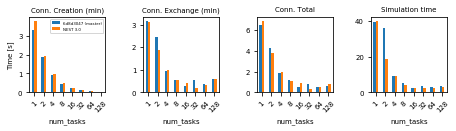

In [66]:
hpc_strong_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_strong_scaling.csv')
hpc_strong_m['Case'] = ['6d8d3047 (master)'] * len(hpc_strong_m)
hpc_strong_3 = pd.read_csv('results/hpc_benchmark_3_0_daint_strong_scaling.csv')
hpc_strong_3['Case'] = ['NEST 3.0'] * len(hpc_strong_3)

hpc_strong = pd.concat([hpc_strong_m, hpc_strong_3])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']
hpc_strong_p = plot_compare(hpc_strong, 'figures/hpc_benchmark_strong_scaling.pdf', values=values, index='num_tasks',
                            legend_loc='upper right')

hpc_strong_p

### Population model

Conn. Creation (min)            Conn. Exchange (min)             \
Case         6d8d3047 (master)   NEST 3.0    6d8d3047 (master)   NEST 3.0   
num_tasks                                                                   
1                          NaN        NaN                  NaN        NaN   
2                          NaN        NaN                  NaN        NaN   
4                          NaN        NaN                  NaN        NaN   
8                   118.997228  90.560710            58.489496  55.220412   
16                   84.344661  54.816632            28.174133  26.375661   
32                   66.665241  36.752460            14.249193  13.635903   
64                   57.662544  27.547343             7.238075   6.981922   
128                  38.256841  23.364649             4.629198   3.994257   

                Conn. Total              
Case      6d8d3047 (master)    NEST 3.0  
num_tasks                                
1                       NaN         NaN  
2                       NaN         NaN  
4                       NaN         NaN  
8                178.294726  148.677884  
16               113.534168   82.126435  
32                81.843442   51.183455  
64                74.926960   35.009812  
128               64.025928   27.819271

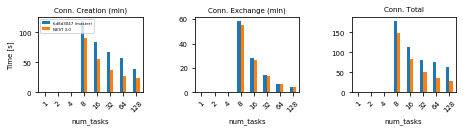

In [100]:
population_strong_m = pd.read_csv('results/population_model_6d8d3047_daint_strong_scaling_in.csv')
population_strong_m['Case'] = ['6d8d3047 (master)'] * len(population_strong_m)
population_strong_3 = pd.read_csv('results/population_model_3_0_daint_strong_scaling_in.csv')
population_strong_3['Case'] = ['NEST 3.0'] * len(population_strong_3)

population_strong = pd.concat([population_strong_m, population_strong_3])

population_strong = calculate_T_conn_and_memory(population_strong)
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']
population_strong_p = plot_compare(population_strong, 'figures/population_model_strong_scaling.pdf', values=values,
                                   index='num_tasks', plot_T_sim=False, legend_loc='upper left')

population_strong_p

### Attemt to reproduce Jordan et. all (2018) appendix, fig. 4

Trenger en mindre scale

Conn. Creation (min)          Conn. Exchange (min)           \
Case       6d8d3047 (master) NEST 3.0    6d8d3047 (master) NEST 3.0   
threads                                                               
1                      50.40    54.76                36.70    36.63   
3                      30.81    31.98                26.41    23.89   
6                      22.64    23.88                21.35    21.33   
9                      16.59    17.95                18.61    18.70   
18                     12.10    14.02                15.62    15.60   
36                      9.08    11.99                16.70    16.60   

              Conn. Total            Simulation time           \
Case    6d8d3047 (master) NEST 3.0 6d8d3047 (master) NEST 3.0   
threads                                                         
1                   87.69    92.75            202.97   227.84   
3                   58.35    57.60            104.01   110.50   
6                   44.95    46.84             54.59    56.75   
9                   36.05    38.00             40.05    57.76   
18                  28.42    31.27             23.80    25.13   
36                  26.15    29.17             15.83    16.32   

                   T_nrns           
Case    6d8d3047 (master) NEST 3.0  
threads                             
1                    0.21     0.14  
3                    0.28     0.40  
6                    0.32     0.39  
9                    0.32     0.20  
18                   0.36     0.37  
36                   0.54     0.43

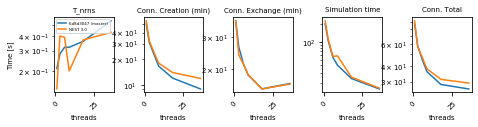

In [117]:
hpc_j_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_strong_scaling_over_threads.csv')
hpc_j_m['Case'] = ['6d8d3047 (master)'] * len(hpc_j_m)
hpc_j_3 = pd.read_csv('results/hpc_benchmark_3_0_daint_strong_scaling_over_threads.csv')
hpc_j_3['Case'] = ['NEST 3.0'] * len(hpc_j_3)

hpc_j = pd.concat([hpc_j_m, hpc_j_3])

hpc_j['VSize_nodes_sum'] = [None] * len(hpc_j)
hpc_j['VSize_ini_sum'] = [None] * len(hpc_j)
hpc_j = calculate_T_conn_and_memory(hpc_j)
hpc_j['threads'] = hpc_j['THREADS_PER_TASK']
values=['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']

hpc_j_p = plot_compare(hpc_j, 'figures/hpc_benchmark_strong_scaling_over_threads.pdf', index='threads',
                       values=values, legend_loc='upper left', plot_kind='line', logy=True)

hpc_j_p

## Compare versions

### num. nodes = 1,  num. threads = {1,3,6,9,18,36}, num. vps=36

Conn. Creation (min)                                            \
Case                    2.14    2.16   2.18 6d8d3047 (master) NEST 3.0   
threads                                                                  
1                      36.44   21.73  17.62             17.42    18.83   
3                      47.89   38.73  30.85             30.24    32.47   
6                      52.17   51.38  42.25             41.48    43.56   
9                      53.47   58.84  43.85             42.44    46.28   
18                     54.55   81.97  56.37             56.02    71.54   
36                     61.78  124.92  74.22             74.35   108.66   

        Conn. Exchange (min)                                           \
Case                    2.14   2.16   2.18 6d8d3047 (master) NEST 3.0   
threads                                                                 
1                       0.62  18.79  11.87             11.69    11.67   
3                       0.89  29.74  24.27             24.48    23.32   
6                       0.96  35.99  32.64             32.80    31.83   
9                       0.91  50.30  48.41             45.36    45.06   
18                      1.38  66.25  68.98             68.54    73.30   
36                      1.44  91.19  77.44             77.49    77.72   

          ...    Memory per VP                                        \
Case      ...             2.14      2.16      2.18 6d8d3047 (master)   
threads   ...                                                          
1         ...         2.312773  5.072531  3.096897          3.097431   
3         ...         2.028328  4.422857  2.269574          2.295633   
6         ...         1.983972  4.332034  2.121685          2.118519   
9         ...         1.973401  4.311907  2.100494          2.067026   
18        ...         1.963256  4.293865  2.008091          1.997216   
36        ...         1.968212  4.284930  1.989075          1.989090   

                  Simulation time                                             
Case     NEST 3.0            2.14    2.16    2.18 6d8d3047 (master) NEST 3.0  
threads                                                                       
1        3.097244           85.58   87.81   92.16             89.93    98.86  
3        2.308753          121.11  128.25  126.82            123.51   131.22  
6        2.073484          128.85  131.90  134.71            133.43   137.56  
9        2.098363          124.27  135.43  136.02            129.22   135.80  
18       2.016601          130.37  137.20  137.85            135.70   139.79  
36       2.018070          173.78  187.95  204.53            203.74   210.48  

[6 rows x 25 columns]

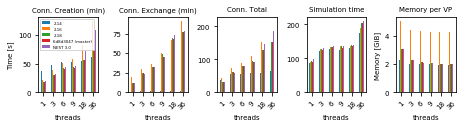

In [84]:
hpc_214 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_threads_SCALE15.csv')
hpc_214['Case'] = ['2.14']*len(hpc_214)
hpc_216 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_threads_SCALE15.csv')
hpc_216['Case'] = ['2.16']*len(hpc_216)
hpc_218 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_threads_SCALE15.csv')
hpc_218['Case'] = ['2.18']*len(hpc_218)
hpc_m   = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_threads_s15.csv')
hpc_m['Case']   = ['6d8d3047 (master)']*len(hpc_m)
hpc_3   = pd.read_csv('results/hpc_benchmark_3_0_daint_threads_s15.csv')
hpc_3['Case']   = ['NEST 3.0']*len(hpc_3)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_m, hpc_3])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['threads'] = hpc_versions['THREADS_PER_TASK']
hpc_versions_p = plot_compare(hpc_versions, 'figures/hpc_different_versions.pdf', index='threads',
                              plot_T_sim=True, legend_loc='upper left',
                              rot=45)
hpc_versions_p

### num. threads = 1, num. nodes = {1, 2, 4, 8, 16, 32}, num. vps = 36

Conn. Creation (min)                                           \
Case                 2.14   2.16   2.18 6d8d3047 (master) NEST 3.0   
N_VP                                                                 
36                  35.65  21.84  17.56             17.53    18.82   
72                  37.68  21.74  17.36             17.18    19.03   
144                 39.38  21.71  17.38             17.33    18.97   
288                 40.99  22.01  17.39             17.20    19.15   
576                 42.90  21.77  17.39             17.23    19.44   
1152                43.87  21.73  17.37             17.12    20.17   

     Conn. Exchange (min)                                            ...     \
Case                 2.14   2.16   2.18 6d8d3047 (master) NEST 3.0   ...      
N_VP                                                                 ...      
36                   0.60  18.22  11.78             11.96    11.71   ...      
72                   0.63  18.84  11.78             11.91    12.04   ...      
144                  0.58  22.50  12.36             12.13    12.12   ...      
288                  0.67  22.05  13.03             13.41    13.53   ...      
576                  0.90  24.56  15.09             15.27    15.39   ...      
1152                 1.28  29.25  19.17             20.06    18.79   ...      

     Memory per VP                                                  \
Case          2.14      2.16      2.18 6d8d3047 (master)  NEST 3.0   
N_VP                                                                 
36        2.312611  5.072531  3.096897          3.097431  3.097243   
72        2.327074  5.073708  3.107514          3.108052  3.107861   
144       2.707514  5.075892  3.109698          3.110236  3.110045   
288       3.149024  5.080248  3.114054          3.114592  3.114401   
576       3.144015  5.108859  3.578192          3.578964  3.577908   
1152      3.161597  5.123802  4.092529          4.091714  4.098217   

     Simulation time                                             
Case            2.14    2.16    2.18 6d8d3047 (master) NEST 3.0  
N_VP                                                             
36             82.85   88.38   90.13             90.82    97.74  
72             84.19   87.63   90.85             90.70    97.94  
144            87.78   92.08   95.31             95.48   102.74  
288            97.88  105.33  105.49            106.74   114.11  
576           110.44  119.03  128.16            129.06   137.00  
1152          140.54  163.31  172.90            176.92   234.30  

[6 rows x 25 columns]

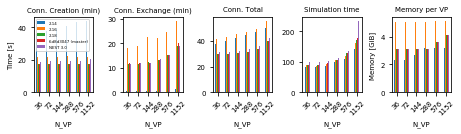

In [80]:
hpc_214_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214_t1['Case'] = ['2.14']*len(hpc_214_t1)
hpc_216_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216_t1['Case'] = ['2.16']*len(hpc_216_t1)
hpc_218_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218_t1['Case'] = ['2.18']*len(hpc_218_t1)
hpc_m_t1   = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_t1_s15.csv')
hpc_m_t1['Case']   = ['6d8d3047 (master)']*len(hpc_m_t1)
hpc_3_t1   = pd.read_csv('results/hpc_benchmark_3_0_daint_t1_s15.csv')
hpc_3_t1['Case']   = ['NEST 3.0']*len(hpc_3_t1)

hpc_versions_t1 = pd.concat([hpc_214_t1, hpc_216_t1, hpc_218_t1, hpc_m_t1, hpc_3_t1])

hpc_versions_t1 = calculate_T_conn_and_memory(hpc_versions_t1)
hpc_versions_t1_p = plot_compare(hpc_versions_t1, 'figures/hpc_different_versions_t1.pdf', legend_loc='upper left',
                                 rot=45)

hpc_versions_t1_p